In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Transit fitting

*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

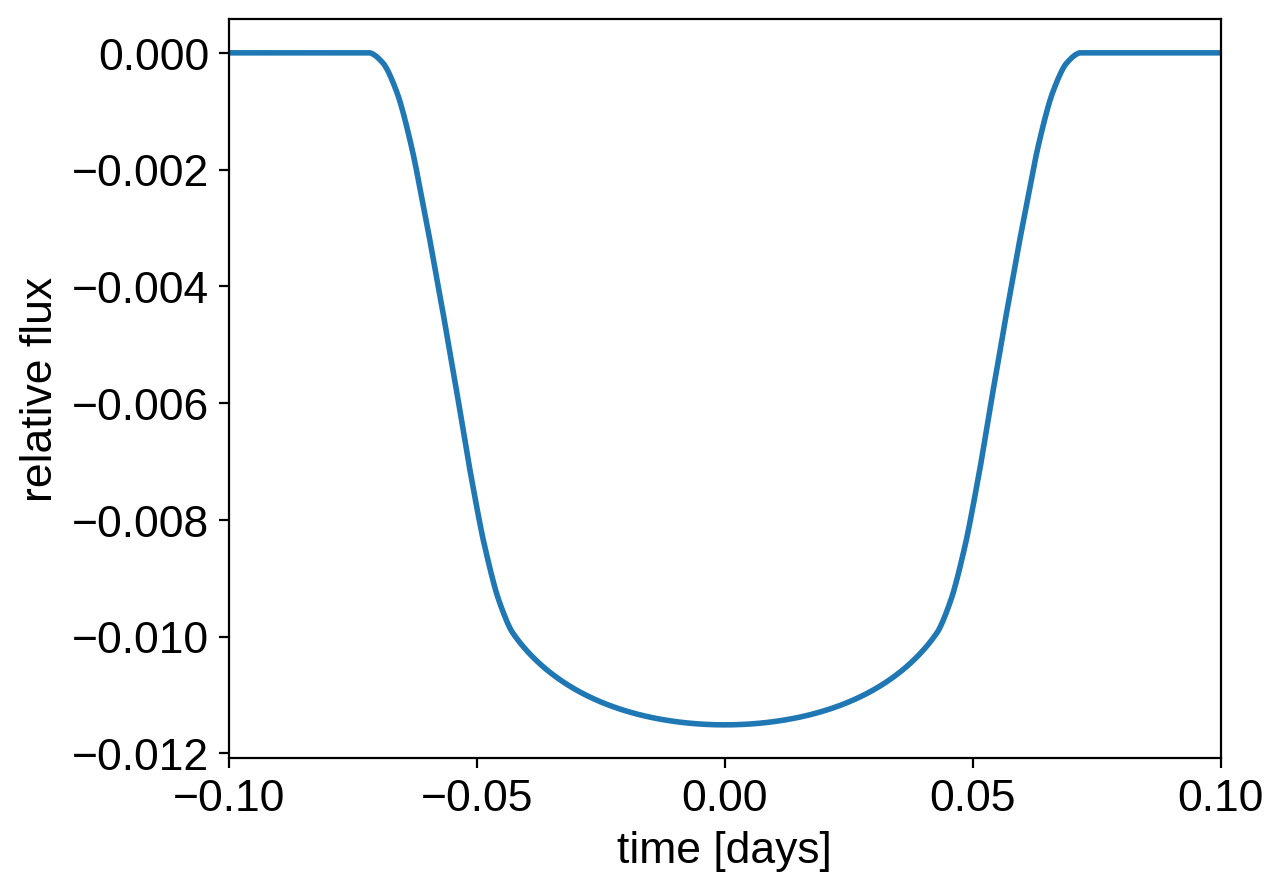

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=3.456)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.1, 0.1, 1000)
u = [0.3, 0.2]
light_curve = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=0.1, t=t, texp=0.02)
    .eval()
)
# Note: the `eval` is needed because this is using Theano in
# the background

plt.plot(t, light_curve, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

But the real power comes from the fact that this is defined as a [Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [4]:
np.random.seed(123)
periods = np.random.uniform(5, 20, 2)
t0s = periods * np.random.rand(2)
t = np.arange(0, 80, 0.02)
yerr = 5e-4

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009).
This reparameterizations is implemented in *exoplanet* as custom *PyMC3* distribution :class:`exoplanet.distributions.QuadLimbDark`.

In [5]:
import pymc3 as pm

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=2)

    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    r = pm.Uniform(
        "r", lower=0.01, upper=0.1, shape=2, testval=np.array([0.04, 0.06])
    )
    b = xo.distributions.ImpactParameter(
        "b", ror=r, shape=2, testval=np.random.rand(2)
    )

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, r=r, t=t
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # In this line, we simulate the dataset that we will fit
    y = xo.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: [b, r, u, logP, t0, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.478798e+04]

1it [00:00, 284.86it/s, logp=2.478798e+04]

2it [00:00, 371.24it/s, logp=-4.973052e+09]

3it [00:00, 420.85it/s, logp=2.478859e+04] 

4it [00:00, 432.77it/s, logp=2.478913e+04]

5it [00:00, 443.67it/s, logp=2.478977e+04]

6it [00:00, 324.31it/s, logp=2.479074e+04]

7it [00:00, 344.29it/s, logp=2.478483e+04]

8it [00:00, 365.80it/s, logp=2.479082e+04]

9it [00:00, 380.49it/s, logp=2.479098e+04]

10it [00:00, 394.68it/s, logp=2.479151e+04]

11it [00:00, 404.00it/s, logp=2.479065e+04]

12it [00:00, 408.86it/s, logp=2.479174e+04]

13it [00:00, 415.66it/s, logp=2.479145e+04]

14it [00:00, 417.13it/s, logp=2.479182e+04]

15it [00:00, 415.95it/s, logp=2.479195e+04]

16it [00:00, 422.20it/s, logp=2.479239e+04]

17it [00:00, 424.53it/s, logp=2.479094e+04]

18it [00:00, 430.42it/s, logp=2.479253e+04]

19it [00:00, 433.49it/s, logp=2.479279e+04]

20it [00:00, 425.08it/s, logp=2.479323e+04]

21it [00:00, 425.59it/s, logp=2.479351e+04]

22it [00:00, 427.47it/s, logp=2.479354e+04]

23it [00:00, 428.39it/s, logp=2.479354e+04]

24it [00:00, 430.96it/s, logp=2.479354e+04]

25it [00:00, 426.66it/s, logp=2.479354e+04]

26it [00:00, 427.97it/s, logp=2.479354e+04]

27it [00:00, 428.27it/s, logp=2.479354e+04]

28it [00:00, 430.91it/s, logp=2.479354e+04]

29it [00:00, 433.87it/s, logp=2.479354e+04]

30it [00:00, 435.72it/s, logp=2.479354e+04]

31it [00:00, 439.49it/s, logp=2.479354e+04]

32it [00:00, 443.04it/s, logp=2.479354e+04]

33it [00:00, 447.26it/s, logp=2.479354e+04]

34it [00:00, 448.35it/s, logp=2.479354e+04]

35it [00:00, 451.28it/s, logp=2.479354e+04]

36it [00:00, 454.50it/s, logp=2.479354e+04]

37it [00:00, 458.13it/s, logp=2.479354e+04]

38it [00:00, 459.79it/s, logp=2.479354e+04]

39it [00:00, 459.40it/s, logp=2.479354e+04]

40it [00:00, 461.89it/s, logp=2.479354e+04]

41it [00:00, 463.07it/s, logp=2.479354e+04]

42it [00:00, 466.98it/s, logp=2.479354e+04]

43it [00:00, 469.30it/s, logp=2.479354e+04]

44it [00:00, 471.21it/s, logp=2.479354e+04]

45it [00:00, 474.78it/s, logp=2.479354e+04]

46it [00:00, 477.17it/s, logp=2.479354e+04]

47it [00:00, 479.80it/s, logp=2.479354e+04]

48it [00:00, 483.09it/s, logp=2.479354e+04]

49it [00:00, 486.40it/s, logp=2.479354e+04]

50it [00:00, 494.08it/s, logp=2.479354e+04]

50it [00:00, 494.08it/s, logp=2.479354e+04]

51it [00:00, 494.08it/s, logp=2.479354e+04]

52it [00:00, 494.08it/s, logp=2.479354e+04]

53it [00:00, 494.08it/s, logp=2.479354e+04]

54it [00:00, 494.08it/s, logp=2.479354e+04]

55it [00:00, 494.08it/s, logp=2.479354e+04]

56it [00:00, 494.08it/s, logp=2.479354e+04]

57it [00:00, 494.08it/s, logp=2.479354e+04]

58it [00:00, 494.08it/s, logp=2.479354e+04]

59it [00:00, 494.08it/s, logp=2.479354e+04]

60it [00:00, 494.08it/s, logp=2.479354e+04]

61it [00:00, 494.08it/s, logp=2.479354e+04]

62it [00:00, 494.08it/s, logp=2.479354e+04]

63it [00:00, 494.08it/s, logp=2.479354e+04]

64it [00:00, 494.08it/s, logp=2.479354e+04]

65it [00:00, 494.08it/s, logp=2.479354e+04]

66it [00:00, 494.08it/s, logp=2.479354e+04]

67it [00:00, 494.08it/s, logp=2.479354e+04]

68it [00:00, 494.08it/s, logp=2.479354e+04]

69it [00:00, 494.08it/s, logp=2.479354e+04]

70it [00:00, 494.08it/s, logp=2.479354e+04]

71it [00:00, 494.08it/s, logp=2.479354e+04]

72it [00:00, 494.08it/s, logp=2.479354e+04]

73it [00:00, 494.08it/s, logp=2.479354e+04]

74it [00:00, 494.08it/s, logp=2.479354e+04]

75it [00:00, 494.08it/s, logp=2.479354e+04]

76it [00:00, 494.08it/s, logp=2.479354e+04]

77it [00:00, 494.08it/s, logp=2.479354e+04]

78it [00:00, 494.08it/s, logp=2.479354e+04]

79it [00:00, 494.08it/s, logp=2.479354e+04]

80it [00:00, 494.08it/s, logp=2.479354e+04]

81it [00:00, 494.08it/s, logp=2.479354e+04]

82it [00:00, 494.08it/s, logp=2.479354e+04]

83it [00:00, 494.08it/s, logp=2.479354e+04]

84it [00:00, 494.08it/s, logp=2.479354e+04]

85it [00:00, 494.08it/s, logp=2.479354e+04]

86it [00:00, 494.08it/s, logp=2.479354e+04]

87it [00:00, 494.08it/s, logp=2.479354e+04]

88it [00:00, 494.08it/s, logp=2.479354e+04]

89it [00:00, 494.08it/s, logp=2.479354e+04]

90it [00:00, 494.08it/s, logp=2.479354e+04]

91it [00:00, 494.08it/s, logp=2.479354e+04]

92it [00:00, 494.08it/s, logp=2.479354e+04]

93it [00:00, 494.08it/s, logp=2.479354e+04]

94it [00:00, 494.08it/s, logp=2.479354e+04]

95it [00:00, 494.08it/s, logp=2.479354e+04]

96it [00:00, 494.08it/s, logp=2.479354e+04]

97it [00:00, 494.08it/s, logp=2.479354e+04]

98it [00:00, 494.08it/s, logp=2.479354e+04]

99it [00:00, 494.08it/s, logp=2.479354e+04]

100it [00:00, 494.08it/s, logp=2.479354e+04]

101it [00:00, 494.08it/s, logp=2.479354e+04]

102it [00:00, 494.08it/s, logp=2.479354e+04]

103it [00:00, 494.08it/s, logp=2.479354e+04]

104it [00:00, 494.08it/s, logp=2.479354e+04]

105it [00:00, 494.08it/s, logp=2.479354e+04]

106it [00:00, 494.08it/s, logp=2.479354e+04]

107it [00:00, 494.08it/s, logp=2.479354e+04]

108it [00:00, 494.08it/s, logp=2.479354e+04]

109it [00:00, 494.08it/s, logp=2.479354e+04]

110it [00:00, 494.08it/s, logp=2.479354e+04]

111it [00:00, 523.23it/s, logp=2.479354e+04]

111it [00:00, 523.23it/s, logp=2.479354e+04]

112it [00:00, 523.23it/s, logp=2.479354e+04]

113it [00:00, 523.23it/s, logp=2.479354e+04]

114it [00:00, 523.23it/s, logp=2.479354e+04]

115it [00:00, 523.23it/s, logp=2.479354e+04]

116it [00:00, 523.23it/s, logp=2.479354e+04]

117it [00:00, 523.23it/s, logp=2.479354e+04]

118it [00:00, 523.23it/s, logp=2.479354e+04]

119it [00:00, 523.23it/s, logp=2.479354e+04]

120it [00:00, 523.23it/s, logp=2.479354e+04]

121it [00:00, 523.23it/s, logp=2.479354e+04]

122it [00:00, 523.23it/s, logp=2.479354e+04]

123it [00:00, 523.23it/s, logp=2.479354e+04]

124it [00:00, 523.23it/s, logp=2.479354e+04]

125it [00:00, 523.23it/s, logp=2.479354e+04]

126it [00:00, 523.23it/s, logp=2.479354e+04]

127it [00:00, 523.23it/s, logp=2.479354e+04]

128it [00:00, 523.23it/s, logp=2.479354e+04]

129it [00:00, 523.23it/s, logp=2.479354e+04]

130it [00:00, 523.23it/s, logp=2.479354e+04]

131it [00:00, 523.23it/s, logp=2.479354e+04]

132it [00:06, 19.39it/s, logp=2.479354e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 24787.977771807487 -> 24793.539425611267


Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

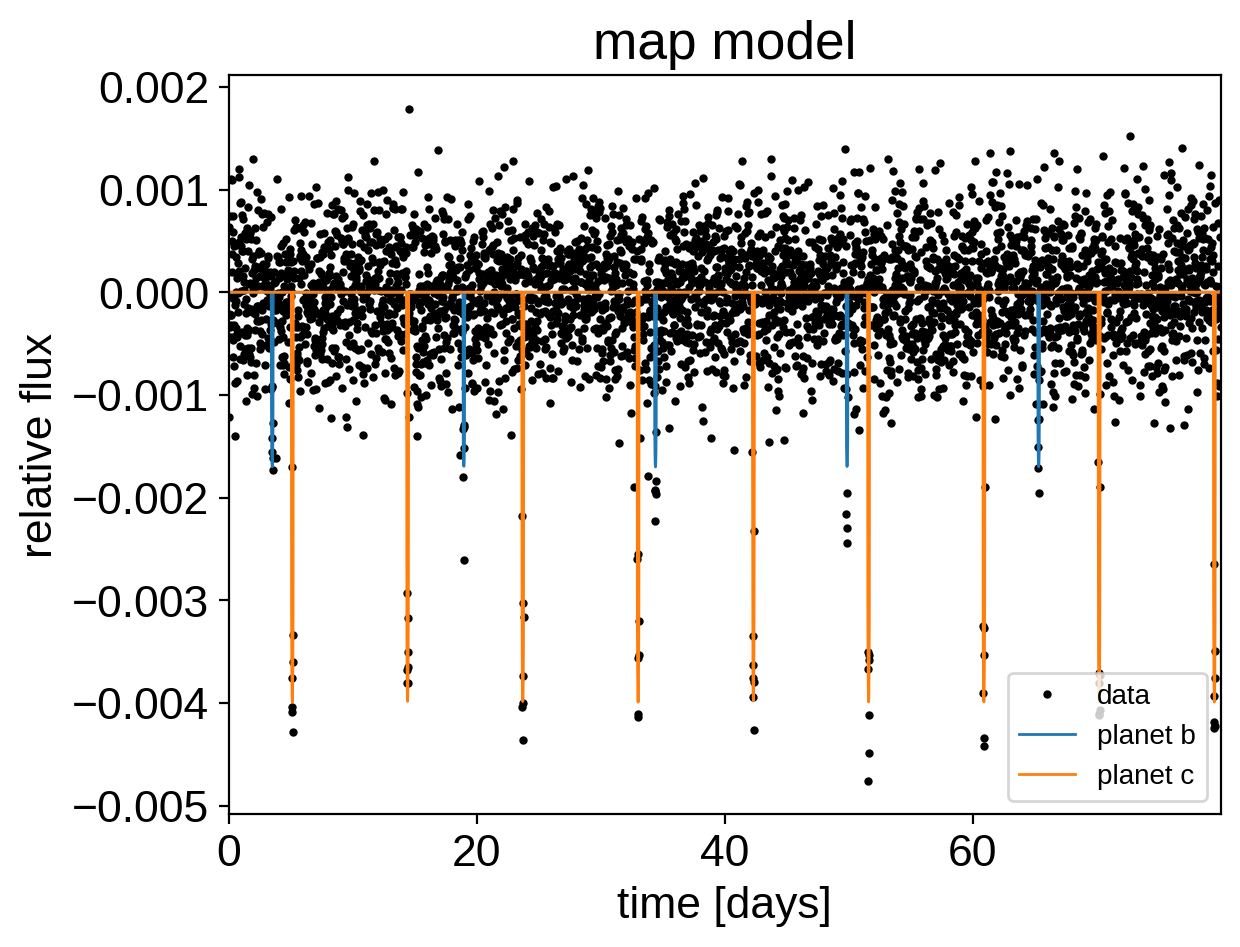

In [6]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(
        t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l)
    )
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use :func:`exoplanet.get_dense_nuts_step`.

In [7]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=3000,
        draws=3000,
        start=map_soln,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [b, r, u, logP, t0, mean]


Sampling 2 chains, 0 divergences:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 11/12000 [00:00<04:08, 48.24draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 13/12000 [00:00<08:57, 22.29draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 15/12000 [00:00<12:27, 16.03draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 17/12000 [00:00<15:13, 13.12draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 19/12000 [00:01<16:41, 11.96draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 21/12000 [00:01<17:42, 11.27draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 23/12000 [00:01<18:31, 10.77draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 25/12000 [00:01<18:54, 10.55draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 27/12000 [00:01<18:58, 10.52draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 29/12000 [00:02<18:56, 10.54draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 31/12000 [00:02<19:04, 10.45draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 34/12000 [00:02<17:24, 11.46draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 36/12000 [00:02<18:53, 10.56draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 38/12000 [00:02<19:36, 10.17draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 40/12000 [00:03<20:15,  9.84draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 42/12000 [00:03<20:02,  9.94draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 44/12000 [00:03<19:55, 10.00draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 46/12000 [00:03<19:49, 10.05draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 49/12000 [00:03<17:54, 11.12draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 51/12000 [00:04<18:30, 10.76draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 53/12000 [00:04<18:57, 10.50draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 55/12000 [00:04<19:17, 10.32draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 57/12000 [00:04<19:51, 10.02draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 59/12000 [00:04<20:11,  9.86draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 61/12000 [00:05<20:15,  9.82draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 64/12000 [00:05<18:13, 10.92draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 66/12000 [00:05<18:57, 10.49draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 68/12000 [00:05<19:52, 10.00draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 70/12000 [00:05<20:10,  9.86draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 72/12000 [00:06<20:12,  9.84draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 74/12000 [00:06<20:40,  9.61draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 76/12000 [00:06<20:31,  9.68draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 78/12000 [00:06<20:31,  9.68draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 80/12000 [00:07<20:39,  9.61draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 82/12000 [00:07<20:35,  9.65draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 84/12000 [00:07<20:38,  9.62draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 86/12000 [00:07<20:15,  9.80draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 88/12000 [00:07<20:01,  9.91draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 90/12000 [00:08<20:33,  9.65draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 92/12000 [00:08<20:33,  9.65draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 94/12000 [00:08<20:05,  9.88draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 96/12000 [00:08<20:00,  9.92draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 98/12000 [00:08<20:35,  9.63draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 100/12000 [00:09<20:33,  9.65draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 102/12000 [00:09<20:21,  9.74draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 104/12000 [00:09<20:02,  9.90draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 106/12000 [00:09<19:50,  9.99draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 108/12000 [00:09<20:02,  9.89draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 110/12000 [00:10<20:09,  9.83draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 112/12000 [00:10<20:06,  9.85draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 114/12000 [00:10<20:07,  9.85draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 116/12000 [00:10<19:58,  9.91draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 118/12000 [00:10<20:08,  9.83draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 120/12000 [00:11<19:58,  9.91draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 122/12000 [00:11<19:49,  9.98draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 124/12000 [00:11<20:22,  9.72draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 126/12000 [00:11<20:01,  9.88draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 128/12000 [00:11<20:10,  9.80draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 130/12000 [00:12<19:54,  9.94draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 132/12000 [00:12<19:44, 10.02draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 134/12000 [00:12<19:55,  9.92draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 136/12000 [00:12<19:41, 10.04draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 138/12000 [00:12<19:44, 10.01draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 140/12000 [00:13<19:35, 10.09draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 142/12000 [00:13<19:48,  9.98draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 144/12000 [00:13<19:50,  9.96draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 146/12000 [00:13<19:48,  9.98draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 148/12000 [00:13<19:48,  9.98draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 150/12000 [00:14<19:50,  9.95draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 152/12000 [00:14<19:47,  9.98draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 154/12000 [00:14<19:46,  9.99draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 156/12000 [00:14<19:52,  9.94draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 158/12000 [00:14<20:02,  9.85draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 160/12000 [00:15<20:02,  9.85draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 162/12000 [00:15<20:15,  9.74draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 164/12000 [00:15<19:58,  9.88draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 166/12000 [00:15<19:42, 10.01draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 168/12000 [00:15<19:55,  9.89draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 170/12000 [00:16<19:39, 10.03draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 172/12000 [00:16<19:25, 10.15draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 174/12000 [00:16<19:28, 10.12draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 176/12000 [00:16<19:22, 10.17draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 178/12000 [00:16<19:33, 10.08draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 180/12000 [00:17<19:21, 10.17draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 182/12000 [00:17<19:21, 10.17draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 184/12000 [00:17<19:28, 10.11draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 187/12000 [00:17<17:38, 11.16draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 189/12000 [00:17<19:13, 10.24draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 191/12000 [00:18<19:49,  9.93draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 193/12000 [00:18<19:48,  9.94draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 195/12000 [00:18<19:32, 10.07draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 197/12000 [00:18<19:26, 10.12draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 200/12000 [00:18<17:28, 11.26draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 202/12000 [00:19<18:06, 10.86draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 204/12000 [00:19<18:17, 10.75draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 206/12000 [00:19<18:38, 10.55draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 208/12000 [00:19<18:31, 10.61draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 210/12000 [00:19<19:04, 10.30draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 212/12000 [00:20<19:31, 10.06draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 214/12000 [00:20<19:56,  9.85draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 215/12000 [00:20<20:32,  9.56draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 217/12000 [00:20<20:09,  9.74draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 219/12000 [00:20<19:57,  9.84draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 221/12000 [00:21<20:33,  9.55draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 223/12000 [00:21<20:26,  9.60draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 225/12000 [00:21<20:05,  9.77draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 227/12000 [00:21<20:11,  9.71draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 229/12000 [00:21<19:55,  9.84draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 231/12000 [00:22<19:41,  9.96draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 233/12000 [00:22<19:27, 10.08draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 235/12000 [00:22<19:20, 10.14draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 237/12000 [00:22<19:29, 10.06draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 239/12000 [00:22<19:27, 10.07draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 241/12000 [00:23<19:27, 10.07draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 243/12000 [00:23<19:26, 10.08draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 245/12000 [00:23<19:13, 10.19draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 247/12000 [00:23<19:12, 10.20draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 249/12000 [00:23<19:17, 10.15draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 251/12000 [00:24<19:43,  9.93draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 253/12000 [00:24<19:34, 10.01draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 255/12000 [00:24<19:38,  9.97draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 257/12000 [00:24<19:24, 10.08draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 259/12000 [00:24<19:34,  9.99draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 261/12000 [00:25<20:47,  9.41draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 263/12000 [00:25<20:32,  9.52draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 265/12000 [00:25<20:29,  9.55draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 267/12000 [00:25<20:28,  9.55draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 269/12000 [00:25<20:16,  9.65draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 271/12000 [00:26<20:10,  9.69draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 273/12000 [00:26<19:37,  9.96draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 275/12000 [00:26<19:22, 10.09draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 277/12000 [00:26<19:29, 10.03draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 279/12000 [00:26<19:25, 10.06draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 281/12000 [00:27<19:59,  9.77draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 283/12000 [00:27<19:59,  9.77draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 285/12000 [00:27<19:39,  9.93draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 287/12000 [00:27<19:34,  9.98draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 289/12000 [00:27<19:47,  9.86draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 291/12000 [00:28<19:54,  9.81draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 293/12000 [00:28<20:03,  9.73draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 295/12000 [00:28<20:02,  9.73draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 297/12000 [00:28<19:30,  9.99draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 299/12000 [00:28<17:16, 11.29draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 302/12000 [00:29<17:42, 11.01draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 304/12000 [00:29<15:24, 12.65draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 306/12000 [00:29<16:41, 11.67draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 308/12000 [00:29<14:54, 13.07draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 310/12000 [00:29<13:23, 14.54draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 312/12000 [00:29<12:50, 15.17draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 317/12000 [00:29<10:27, 18.61draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 320/12000 [00:30<11:00, 17.68draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 324/12000 [00:30<09:13, 21.11draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 329/12000 [00:30<07:37, 25.48draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 334/12000 [00:30<06:32, 29.69draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 345/12000 [00:30<05:07, 37.95draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 355/12000 [00:30<04:09, 46.62draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 368/12000 [00:30<03:21, 57.62draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 381/12000 [00:30<02:48, 69.11draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 394/12000 [00:30<02:27, 78.94draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 409/12000 [00:30<02:06, 91.72draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 424/12000 [00:31<01:54, 100.96draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 443/12000 [00:31<01:39, 115.90draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 461/12000 [00:31<01:29, 129.16draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 484/12000 [00:31<01:18, 147.32draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 502/12000 [00:31<01:14, 153.76draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 521/12000 [00:31<01:11, 160.40draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 539/12000 [00:31<01:11, 160.89draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 556/12000 [00:31<01:14, 152.67draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 572/12000 [00:31<01:17, 146.72draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 591/12000 [00:32<01:13, 155.90draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 608/12000 [00:32<01:12, 157.72draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 625/12000 [00:32<01:17, 146.55draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 644/12000 [00:32<01:13, 155.02draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 662/12000 [00:32<01:10, 160.85draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 679/12000 [00:32<01:13, 154.92draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 695/12000 [00:32<01:13, 153.72draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 711/12000 [00:32<01:14, 151.84draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 728/12000 [00:32<01:12, 154.79draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 745/12000 [00:33<01:11, 156.82draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 762/12000 [00:33<01:11, 157.36draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 779/12000 [00:33<01:10, 158.85draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 799/12000 [00:33<01:06, 167.84draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 816/12000 [00:33<01:06, 167.57draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 833/12000 [00:33<01:11, 157.19draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 849/12000 [00:33<01:11, 155.86draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 865/12000 [00:33<01:15, 147.65draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 880/12000 [00:33<01:15, 147.60draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 899/12000 [00:34<01:10, 156.90draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 921/12000 [00:34<01:05, 170.36draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 939/12000 [00:34<01:06, 165.75draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 956/12000 [00:34<01:11, 153.51draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 973/12000 [00:34<01:10, 157.26draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 990/12000 [00:34<01:09, 158.44draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1007/12000 [00:34<01:10, 155.46draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1025/12000 [00:34<01:08, 159.87draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1042/12000 [00:34<01:11, 152.93draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1058/12000 [00:35<01:12, 150.55draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1074/12000 [00:35<01:13, 148.51draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1089/12000 [00:35<01:13, 148.10draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1105/12000 [00:35<01:12, 151.20draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1122/12000 [00:35<01:10, 153.96draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1140/12000 [00:35<01:08, 159.10draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1156/12000 [00:35<01:08, 159.17draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1175/12000 [00:35<01:04, 167.02draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1192/12000 [00:35<01:06, 162.75draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1209/12000 [00:36<01:07, 159.50draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1226/12000 [00:36<01:10, 153.65draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1243/12000 [00:36<01:08, 157.31draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1259/12000 [00:36<01:08, 156.28draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1276/12000 [00:36<01:07, 158.01draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1293/12000 [00:36<01:07, 158.95draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1309/12000 [00:36<01:10, 151.80draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1325/12000 [00:36<01:10, 152.02draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1345/12000 [00:36<01:06, 160.97draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 1362/12000 [00:37<01:09, 153.83draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 1378/12000 [00:37<01:09, 152.24draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1397/12000 [00:37<01:06, 158.45draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1414/12000 [00:37<01:09, 152.66draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1431/12000 [00:37<01:09, 152.64draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1450/12000 [00:37<01:06, 157.77draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1470/12000 [00:37<01:03, 166.49draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1487/12000 [00:37<01:06, 157.62draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1504/12000 [00:37<01:06, 156.87draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1521/12000 [00:37<01:05, 160.38draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1539/12000 [00:38<01:04, 163.42draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1556/12000 [00:38<01:07, 154.94draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1572/12000 [00:38<01:08, 152.73draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1588/12000 [00:38<01:08, 151.89draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1604/12000 [00:38<01:08, 152.19draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 1620/12000 [00:38<01:14, 138.44draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 1635/12000 [00:38<01:16, 136.19draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 1649/12000 [00:38<01:15, 136.84draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1666/12000 [00:39<01:13, 141.29draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1683/12000 [00:39<01:10, 146.76draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1698/12000 [00:39<01:10, 146.33draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1713/12000 [00:39<01:10, 146.72draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1728/12000 [00:39<01:11, 144.57draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 1745/12000 [00:39<01:08, 148.82draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 1762/12000 [00:39<01:07, 152.30draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 1780/12000 [00:39<01:05, 156.40draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 1796/12000 [00:39<01:06, 153.72draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 1813/12000 [00:39<01:04, 158.18draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 1829/12000 [00:40<01:05, 156.03draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 1845/12000 [00:40<01:04, 156.99draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1861/12000 [00:40<01:05, 155.49draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1877/12000 [00:40<01:10, 142.92draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1892/12000 [00:40<01:09, 144.74draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1908/12000 [00:40<01:08, 148.20draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1925/12000 [00:40<01:05, 153.57draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1942/12000 [00:40<01:03, 157.57draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 1958/12000 [00:40<01:04, 155.93draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 1976/12000 [00:41<01:02, 161.04draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 1995/12000 [00:41<01:00, 165.96draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2013/12000 [00:41<01:00, 164.98draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2030/12000 [00:41<01:00, 165.45draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2047/12000 [00:41<01:02, 160.37draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2064/12000 [00:41<01:02, 160.05draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2081/12000 [00:41<01:02, 158.82draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2097/12000 [00:41<01:04, 154.71draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2113/12000 [00:41<01:03, 155.95draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2129/12000 [00:41<01:03, 156.12draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2145/12000 [00:42<01:04, 153.17draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2162/12000 [00:42<01:03, 154.89draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2178/12000 [00:42<01:05, 150.03draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2194/12000 [00:42<01:04, 151.22draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2210/12000 [00:42<01:07, 144.58draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 2227/12000 [00:42<01:04, 150.82draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 2243/12000 [00:42<01:04, 151.96draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 2259/12000 [00:42<01:05, 149.20draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 2279/12000 [00:42<01:00, 159.70draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 2298/12000 [00:43<00:57, 167.49draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 2316/12000 [00:43<00:58, 165.70draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 2333/12000 [00:43<00:59, 163.42draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 2350/12000 [00:43<01:00, 158.63draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 2366/12000 [00:43<01:01, 157.33draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 2382/12000 [00:43<01:02, 154.87draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 2398/12000 [00:43<01:01, 156.26draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 2418/12000 [00:43<00:57, 166.06draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 2435/12000 [00:43<00:57, 165.94draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 2452/12000 [00:44<00:59, 161.78draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 2470/12000 [00:44<00:57, 164.35draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 2487/12000 [00:44<00:59, 160.85draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 2504/12000 [00:44<01:01, 155.44draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 2520/12000 [00:44<01:03, 150.23draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 2536/12000 [00:44<01:02, 150.67draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 2552/12000 [00:44<01:02, 150.80draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 2568/12000 [00:44<01:01, 153.01draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2586/12000 [00:44<00:59, 157.91draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2604/12000 [00:44<00:58, 161.74draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2621/12000 [00:45<00:58, 161.11draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2638/12000 [00:45<00:59, 156.98draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2654/12000 [00:45<01:00, 155.47draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2672/12000 [00:45<00:58, 158.94draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2688/12000 [00:45<01:04, 145.00draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2705/12000 [00:45<01:02, 149.74draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2723/12000 [00:45<00:59, 156.56draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2739/12000 [00:45<00:58, 157.18draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2756/12000 [00:45<00:58, 157.87draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2773/12000 [00:46<00:57, 159.39draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2790/12000 [00:46<01:01, 149.93draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2806/12000 [00:46<01:03, 145.63draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 2823/12000 [00:46<01:00, 150.78draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 2839/12000 [00:46<01:00, 152.44draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 2856/12000 [00:46<00:58, 155.14draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 2872/12000 [00:46<00:58, 155.96draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 2888/12000 [00:46<01:00, 149.94draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 2905/12000 [00:46<00:59, 152.02draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 2922/12000 [00:47<00:58, 155.69draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 2940/12000 [00:47<00:56, 160.55draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 2958/12000 [00:47<00:54, 164.49draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 2975/12000 [00:47<00:56, 160.35draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 2993/12000 [00:47<00:55, 162.36draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 3010/12000 [00:47<00:57, 157.28draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 3026/12000 [00:47<00:57, 157.13draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 3044/12000 [00:47<00:56, 159.05draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 3061/12000 [00:47<00:56, 158.63draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 3077/12000 [00:48<00:57, 155.45draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 3093/12000 [00:48<00:59, 149.87draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 3109/12000 [00:48<00:58, 152.38draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 3125/12000 [00:48<01:00, 146.94draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 3140/12000 [00:48<01:00, 145.63draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 3156/12000 [00:48<00:59, 147.92draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 3173/12000 [00:48<00:58, 150.14draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3189/12000 [00:48<00:57, 152.40draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3209/12000 [00:48<00:54, 162.48draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3226/12000 [00:48<00:54, 162.19draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3243/12000 [00:49<00:55, 158.31draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3259/12000 [00:49<00:56, 154.89draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3276/12000 [00:49<00:56, 155.63draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3292/12000 [00:49<00:55, 156.32draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3308/12000 [00:49<00:55, 156.20draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3324/12000 [00:49<00:56, 154.13draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3342/12000 [00:49<00:54, 159.44draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3359/12000 [00:49<00:53, 160.28draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3376/12000 [00:49<00:54, 158.20draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3392/12000 [00:50<00:55, 155.46draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3408/12000 [00:50<00:57, 150.51draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 3425/12000 [00:50<00:55, 154.92draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 3441/12000 [00:50<00:57, 148.50draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 3457/12000 [00:50<00:57, 148.71draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 3473/12000 [00:50<00:57, 148.34draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 3491/12000 [00:50<00:55, 154.23draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 3508/12000 [00:50<00:53, 157.42draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 3525/12000 [00:50<00:53, 157.86draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 3543/12000 [00:51<00:51, 163.74draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 3560/12000 [00:51<00:51, 163.78draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 3577/12000 [00:51<00:51, 162.51draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 3594/12000 [00:51<00:51, 164.26draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 3611/12000 [00:51<00:51, 163.63draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 3628/12000 [00:51<00:50, 164.87draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 3645/12000 [00:51<00:51, 162.26draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 3663/12000 [00:51<00:50, 166.71draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 3680/12000 [00:51<00:50, 165.46draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 3697/12000 [00:51<00:52, 159.33draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 3714/12000 [00:52<00:52, 158.79draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 3732/12000 [00:52<00:51, 160.12draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 3749/12000 [00:52<00:52, 158.58draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 3765/12000 [00:52<00:52, 156.20draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3782/12000 [00:52<00:51, 159.54draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3799/12000 [00:52<00:51, 158.60draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3817/12000 [00:52<00:50, 161.10draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3834/12000 [00:52<00:56, 143.75draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3849/12000 [00:52<00:56, 143.38draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3865/12000 [00:53<00:56, 143.82draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3881/12000 [00:53<00:55, 146.22draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3896/12000 [00:53<00:55, 145.33draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 3911/12000 [00:53<00:56, 143.90draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 3928/12000 [00:53<00:54, 149.36draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 3944/12000 [00:53<00:53, 150.44draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 3960/12000 [00:53<00:54, 147.86draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 3977/12000 [00:53<00:53, 151.19draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 3996/12000 [00:53<00:50, 158.80draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 4014/12000 [00:54<00:49, 161.65draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 4031/12000 [00:54<00:48, 163.01draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 4049/12000 [00:54<00:47, 166.63draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 4066/12000 [00:54<00:49, 159.78draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 4083/12000 [00:54<00:49, 158.57draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 4099/12000 [00:54<00:51, 154.62draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 4116/12000 [00:54<00:50, 155.41draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 4132/12000 [00:54<00:50, 155.61draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 4149/12000 [00:54<00:49, 158.97draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 4165/12000 [00:55<00:50, 154.13draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 4181/12000 [00:55<00:51, 151.92draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 4199/12000 [00:55<00:49, 157.92draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 4215/12000 [00:55<00:53, 145.28draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 4233/12000 [00:55<00:51, 149.58draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 4249/12000 [00:55<00:51, 150.55draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4265/12000 [00:55<00:51, 151.26draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4281/12000 [00:55<00:50, 152.82draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4297/12000 [00:55<00:52, 148.04draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4312/12000 [00:56<00:54, 140.46draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4329/12000 [00:56<00:52, 147.07draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4347/12000 [00:56<00:49, 154.10draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 4364/12000 [00:56<00:48, 158.04draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 4380/12000 [00:56<00:50, 150.39draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4397/12000 [00:56<00:48, 155.61draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4414/12000 [00:56<00:48, 155.21draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4434/12000 [00:56<00:46, 161.94draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4451/12000 [00:56<00:46, 162.07draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4468/12000 [00:56<00:45, 164.21draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4485/12000 [00:57<00:46, 163.21draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4503/12000 [00:57<00:45, 166.01draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4522/12000 [00:57<00:43, 171.44draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4540/12000 [00:57<00:45, 165.22draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4558/12000 [00:57<00:44, 166.56draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4575/12000 [00:57<00:45, 161.87draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4592/12000 [00:57<00:46, 159.38draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4609/12000 [00:57<00:47, 155.68draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 4625/12000 [00:57<00:48, 152.99draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 4641/12000 [00:58<00:48, 152.11draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 4657/12000 [00:58<00:48, 152.09draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 4673/12000 [00:58<00:48, 152.58draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 4689/12000 [00:58<00:48, 149.48draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 4706/12000 [00:58<00:48, 151.95draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 4723/12000 [00:58<00:47, 154.79draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 4739/12000 [00:58<00:47, 154.39draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 4756/12000 [00:58<00:45, 158.64draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 4773/12000 [00:58<00:45, 158.15draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 4790/12000 [00:59<00:45, 158.21draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 4807/12000 [00:59<00:45, 158.48draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 4823/12000 [00:59<00:45, 157.72draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 4839/12000 [00:59<00:45, 157.97draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 4857/12000 [00:59<00:43, 163.00draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 4874/12000 [00:59<00:45, 158.05draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 4890/12000 [00:59<00:46, 152.94draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 4906/12000 [00:59<00:45, 154.81draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 4924/12000 [00:59<00:44, 157.41draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 4941/12000 [00:59<00:43, 160.54draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 4958/12000 [01:00<00:45, 154.92draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 4975/12000 [01:00<00:44, 159.03draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 4992/12000 [01:00<00:44, 156.53draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5008/12000 [01:00<00:47, 148.45draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5025/12000 [01:00<00:45, 154.01draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5041/12000 [01:00<00:45, 153.63draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5057/12000 [01:00<00:44, 154.50draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5073/12000 [01:00<00:46, 148.87draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5088/12000 [01:00<00:47, 146.80draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5104/12000 [01:01<00:47, 145.32draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5121/12000 [01:01<00:45, 151.82draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5137/12000 [01:01<00:44, 153.68draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5155/12000 [01:01<00:42, 159.70draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5174/12000 [01:01<00:40, 167.56draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5193/12000 [01:01<00:40, 167.89draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5212/12000 [01:01<00:39, 171.44draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 5230/12000 [01:01<00:40, 166.71draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 5247/12000 [01:01<00:41, 164.08draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 5264/12000 [01:02<00:42, 160.05draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 5281/12000 [01:02<00:43, 153.81draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 5300/12000 [01:02<00:41, 162.69draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 5319/12000 [01:02<00:40, 164.22draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 5336/12000 [01:02<00:40, 164.68draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 5353/12000 [01:02<00:40, 163.88draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 5370/12000 [01:02<00:41, 161.15draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 5387/12000 [01:02<00:41, 159.85draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 5405/12000 [01:02<00:39, 165.29draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 5423/12000 [01:02<00:38, 168.74draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 5440/12000 [01:03<00:38, 168.89draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 5460/12000 [01:03<00:37, 174.41draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 5480/12000 [01:03<00:36, 180.13draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 5499/12000 [01:03<00:38, 170.91draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 5517/12000 [01:03<00:37, 172.08draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 5535/12000 [01:03<00:38, 169.71draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 5553/12000 [01:03<00:38, 169.14draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 5571/12000 [01:03<00:38, 167.87draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5588/12000 [01:03<00:38, 165.27draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5607/12000 [01:04<00:37, 169.30draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5624/12000 [01:04<00:38, 164.28draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5641/12000 [01:04<00:38, 163.44draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5658/12000 [01:04<00:38, 165.32draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5675/12000 [01:04<00:38, 166.35draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5692/12000 [01:04<00:39, 158.46draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5708/12000 [01:04<00:40, 156.13draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5724/12000 [01:04<00:41, 150.85draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5740/12000 [01:04<00:40, 152.76draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5758/12000 [01:05<00:40, 154.78draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5775/12000 [01:05<00:39, 156.24draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5792/12000 [01:05<00:39, 158.47draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5808/12000 [01:05<00:39, 157.58draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 5825/12000 [01:05<00:38, 160.10draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 5843/12000 [01:05<00:37, 164.08draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 5860/12000 [01:05<00:37, 165.80draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 5877/12000 [01:05<00:37, 164.08draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 5894/12000 [01:05<00:37, 163.25draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 5911/12000 [01:05<00:36, 164.84draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 5928/12000 [01:06<00:39, 154.68draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 5944/12000 [01:06<00:39, 154.96draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 5960/12000 [01:06<00:38, 155.18draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 5976/12000 [01:06<00:40, 148.74draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 5995/12000 [01:06<00:38, 155.75draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 6011/12000 [01:06<00:38, 156.65draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 6027/12000 [01:06<00:39, 152.65draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 6043/12000 [01:06<00:38, 153.21draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 6059/12000 [01:06<00:38, 153.18draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 6075/12000 [01:07<00:38, 152.34draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 6091/12000 [01:07<00:38, 152.71draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 6108/12000 [01:07<00:38, 154.05draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 6125/12000 [01:07<00:37, 155.84draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 6142/12000 [01:07<00:37, 158.20draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 6159/12000 [01:07<00:36, 159.34draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 6177/12000 [01:07<00:35, 162.58draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6194/12000 [01:07<00:35, 162.59draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6211/12000 [01:07<00:36, 158.56draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6228/12000 [01:07<00:36, 157.02draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6245/12000 [01:08<00:36, 157.74draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6262/12000 [01:08<00:36, 158.64draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6278/12000 [01:08<00:36, 157.10draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6295/12000 [01:08<00:35, 160.50draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6314/12000 [01:08<00:33, 167.60draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6331/12000 [01:08<00:33, 167.69draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6348/12000 [01:08<00:34, 164.51draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6365/12000 [01:08<00:35, 159.71draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6382/12000 [01:08<00:34, 160.65draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6399/12000 [01:09<00:34, 161.34draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6416/12000 [01:09<00:34, 161.94draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 6433/12000 [01:09<00:34, 159.46draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 6449/12000 [01:09<00:35, 158.39draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 6465/12000 [01:09<00:35, 157.16draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 6481/12000 [01:09<00:35, 156.04draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 6498/12000 [01:09<00:34, 158.04draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 6517/12000 [01:09<00:33, 164.98draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 6534/12000 [01:09<00:33, 161.10draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 6551/12000 [01:10<00:34, 155.71draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 6567/12000 [01:10<00:36, 149.60draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 6583/12000 [01:10<00:36, 149.63draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 6599/12000 [01:10<00:35, 152.52draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 6616/12000 [01:10<00:34, 155.53draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 6632/12000 [01:10<00:35, 149.26draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 6648/12000 [01:10<00:35, 149.48draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 6665/12000 [01:10<00:34, 154.08draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 6681/12000 [01:10<00:35, 151.24draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 6697/12000 [01:10<00:34, 152.83draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 6715/12000 [01:11<00:33, 158.23draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 6732/12000 [01:11<00:32, 160.23draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 6750/12000 [01:11<00:31, 164.51draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 6767/12000 [01:11<00:31, 165.97draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6784/12000 [01:11<00:31, 163.23draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6801/12000 [01:11<00:33, 157.21draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6818/12000 [01:11<00:32, 160.32draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6835/12000 [01:11<00:32, 157.38draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6851/12000 [01:11<00:33, 154.33draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6867/12000 [01:12<00:33, 151.01draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6883/12000 [01:12<00:33, 152.29draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 6901/12000 [01:12<00:32, 159.09draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 6920/12000 [01:12<00:30, 164.96draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 6937/12000 [01:12<00:30, 163.63draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 6954/12000 [01:12<00:31, 161.65draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 6972/12000 [01:12<00:30, 163.35draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 6989/12000 [01:12<00:30, 164.48draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 7006/12000 [01:12<00:30, 163.26draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 7023/12000 [01:12<00:30, 163.28draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 7040/12000 [01:13<00:31, 155.10draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7057/12000 [01:13<00:31, 158.02draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7073/12000 [01:13<00:31, 155.68draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7089/12000 [01:13<00:31, 156.33draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7105/12000 [01:13<00:31, 155.87draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7121/12000 [01:13<00:31, 153.88draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7137/12000 [01:13<00:31, 155.14draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 7154/12000 [01:13<00:31, 154.73draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 7173/12000 [01:13<00:29, 163.59draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 7190/12000 [01:14<00:30, 158.95draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 7209/12000 [01:14<00:29, 164.78draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 7226/12000 [01:14<00:29, 160.25draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 7244/12000 [01:14<00:29, 163.72draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7261/12000 [01:14<00:28, 165.10draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7279/12000 [01:14<00:28, 167.74draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7297/12000 [01:14<00:27, 170.58draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7315/12000 [01:14<00:28, 164.57draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7332/12000 [01:14<00:29, 157.23draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7348/12000 [01:15<00:31, 149.11draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 7364/12000 [01:15<00:30, 150.68draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7382/12000 [01:15<00:29, 156.54draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7398/12000 [01:15<00:30, 150.80draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7415/12000 [01:15<00:29, 153.44draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7431/12000 [01:15<00:29, 154.71draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7448/12000 [01:15<00:28, 158.91draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7464/12000 [01:15<00:28, 158.05draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7480/12000 [01:15<00:29, 155.02draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7498/12000 [01:15<00:28, 157.08draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7514/12000 [01:16<00:28, 155.97draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7530/12000 [01:16<00:28, 157.08draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7547/12000 [01:16<00:28, 157.24draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7565/12000 [01:16<00:27, 161.84draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7583/12000 [01:16<00:26, 164.24draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7600/12000 [01:16<00:27, 161.81draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7617/12000 [01:16<00:27, 158.21draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 7634/12000 [01:16<00:27, 158.57draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 7651/12000 [01:16<00:27, 160.44draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 7668/12000 [01:17<00:27, 158.26draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 7684/12000 [01:17<00:28, 153.85draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 7702/12000 [01:17<00:27, 156.18draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 7719/12000 [01:17<00:27, 156.61draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 7736/12000 [01:17<00:27, 157.61draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 7753/12000 [01:17<00:26, 160.74draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 7770/12000 [01:17<00:26, 160.44draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 7787/12000 [01:17<00:26, 157.22draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 7803/12000 [01:17<00:26, 156.62draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 7820/12000 [01:18<00:26, 159.85draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 7837/12000 [01:18<00:26, 157.61draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 7853/12000 [01:18<00:26, 154.91draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 7869/12000 [01:18<00:27, 152.12draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 7885/12000 [01:18<00:26, 154.23draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 7903/12000 [01:18<00:25, 159.30draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 7919/12000 [01:18<00:25, 158.72draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 7937/12000 [01:18<00:25, 161.48draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 7954/12000 [01:18<00:25, 159.38draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 7970/12000 [01:18<00:25, 158.51draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 7990/12000 [01:19<00:23, 167.60draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8007/12000 [01:19<00:24, 164.72draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8024/12000 [01:19<00:24, 164.25draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8041/12000 [01:19<00:24, 164.32draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8058/12000 [01:19<00:23, 165.09draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8076/12000 [01:19<00:23, 167.97draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8095/12000 [01:19<00:22, 171.85draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8113/12000 [01:19<00:22, 171.03draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8131/12000 [01:19<00:23, 164.05draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8148/12000 [01:20<00:24, 160.04draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8165/12000 [01:20<00:23, 160.03draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8182/12000 [01:20<00:23, 160.66draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8199/12000 [01:20<00:24, 154.55draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8217/12000 [01:20<00:24, 157.48draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 8233/12000 [01:20<00:24, 156.87draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 8250/12000 [01:20<00:24, 155.12draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 8266/12000 [01:20<00:24, 153.62draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 8283/12000 [01:20<00:23, 155.87draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 8300/12000 [01:21<00:23, 156.25draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 8317/12000 [01:21<00:23, 157.64draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 8335/12000 [01:21<00:23, 159.04draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 8351/12000 [01:21<00:23, 156.43draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 8367/12000 [01:21<00:23, 152.32draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 8385/12000 [01:21<00:23, 156.74draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 8403/12000 [01:21<00:22, 162.34draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 8420/12000 [01:21<00:22, 158.11draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 8436/12000 [01:21<00:23, 152.67draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 8453/12000 [01:21<00:22, 155.75draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 8469/12000 [01:22<00:23, 153.46draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 8485/12000 [01:22<00:23, 149.41draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 8502/12000 [01:22<00:22, 153.32draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 8519/12000 [01:22<00:22, 155.98draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 8535/12000 [01:22<00:23, 149.49draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 8555/12000 [01:22<00:21, 158.34draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 8572/12000 [01:22<00:21, 158.23draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8590/12000 [01:22<00:21, 161.84draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8607/12000 [01:22<00:21, 160.77draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8626/12000 [01:23<00:20, 167.66draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8643/12000 [01:23<00:20, 164.40draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8660/12000 [01:23<00:20, 165.15draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8677/12000 [01:23<00:20, 164.40draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8694/12000 [01:23<00:20, 162.49draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8711/12000 [01:23<00:20, 158.41draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8728/12000 [01:23<00:20, 160.89draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8746/12000 [01:23<00:19, 164.38draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8764/12000 [01:23<00:19, 165.89draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8781/12000 [01:24<00:19, 161.89draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8799/12000 [01:24<00:19, 164.65draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8816/12000 [01:24<00:19, 164.61draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 8833/12000 [01:24<00:19, 158.74draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 8849/12000 [01:24<00:19, 157.61draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 8866/12000 [01:24<00:19, 159.09draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 8883/12000 [01:24<00:19, 159.50draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 8901/12000 [01:24<00:19, 162.07draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 8920/12000 [01:24<00:18, 165.80draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 8939/12000 [01:24<00:18, 167.63draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 8956/12000 [01:25<00:20, 150.12draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 8972/12000 [01:25<00:21, 143.95draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 8987/12000 [01:25<00:21, 143.33draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 9002/12000 [01:25<00:20, 142.97draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 9017/12000 [01:25<00:21, 139.09draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 9035/12000 [01:25<00:19, 149.21draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 9051/12000 [01:25<00:19, 147.81draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 9066/12000 [01:25<00:19, 148.43draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 9082/12000 [01:25<00:19, 151.63draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 9098/12000 [01:26<00:19, 152.44draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 9114/12000 [01:26<00:18, 152.35draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 9133/12000 [01:26<00:18, 159.27draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 9150/12000 [01:26<00:17, 160.40draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 9167/12000 [01:26<00:17, 160.54draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9184/12000 [01:26<00:17, 158.85draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9200/12000 [01:26<00:17, 158.40draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9217/12000 [01:26<00:17, 160.73draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9234/12000 [01:26<00:17, 159.24draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9250/12000 [01:27<00:17, 157.99draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9266/12000 [01:27<00:17, 156.96draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9282/12000 [01:27<00:17, 155.04draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9298/12000 [01:27<00:18, 148.28draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9315/12000 [01:27<00:17, 152.78draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9332/12000 [01:27<00:17, 155.27draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9349/12000 [01:27<00:17, 155.03draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9366/12000 [01:27<00:16, 158.93draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9382/12000 [01:27<00:17, 153.58draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9399/12000 [01:28<00:16, 156.62draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9415/12000 [01:28<00:16, 155.76draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 9431/12000 [01:28<00:17, 150.56draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 9447/12000 [01:28<00:17, 148.23draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 9464/12000 [01:28<00:16, 151.72draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 9480/12000 [01:28<00:16, 152.25draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 9496/12000 [01:28<00:16, 152.66draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 9512/12000 [01:28<00:16, 151.53draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 9530/12000 [01:28<00:15, 157.49draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 9547/12000 [01:28<00:15, 160.55draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 9565/12000 [01:29<00:14, 162.79draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 9582/12000 [01:29<00:15, 156.48draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 9599/12000 [01:29<00:15, 159.54draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 9616/12000 [01:29<00:15, 158.81draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 9632/12000 [01:29<00:14, 158.66draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 9648/12000 [01:29<00:14, 158.90draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 9665/12000 [01:29<00:14, 161.72draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 9682/12000 [01:29<00:14, 161.59draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 9701/12000 [01:29<00:13, 166.42draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 9718/12000 [01:30<00:14, 162.29draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 9735/12000 [01:30<00:14, 160.74draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 9754/12000 [01:30<00:13, 163.99draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 9771/12000 [01:30<00:13, 161.36draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9788/12000 [01:30<00:13, 161.57draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9805/12000 [01:30<00:13, 163.22draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9822/12000 [01:30<00:13, 156.64draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9838/12000 [01:30<00:13, 155.08draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9855/12000 [01:30<00:13, 156.30draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9873/12000 [01:30<00:13, 158.59draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9889/12000 [01:31<00:13, 153.96draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 9905/12000 [01:31<00:14, 149.41draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 9921/12000 [01:31<00:13, 152.20draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 9937/12000 [01:31<00:13, 152.14draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 9953/12000 [01:31<00:13, 153.01draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 9969/12000 [01:31<00:13, 151.03draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 9987/12000 [01:31<00:12, 156.05draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 10003/12000 [01:31<00:12, 155.85draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 10019/12000 [01:31<00:12, 157.01draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 10035/12000 [01:32<00:12, 156.26draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10052/12000 [01:32<00:12, 158.69draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10069/12000 [01:32<00:11, 161.90draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10086/12000 [01:32<00:11, 162.85draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10103/12000 [01:32<00:11, 161.27draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10120/12000 [01:32<00:11, 157.50draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10136/12000 [01:32<00:11, 157.75draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 10152/12000 [01:32<00:11, 158.01draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 10168/12000 [01:32<00:11, 157.35draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 10184/12000 [01:32<00:11, 153.78draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 10201/12000 [01:33<00:11, 154.40draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 10219/12000 [01:33<00:11, 157.01draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 10237/12000 [01:33<00:11, 160.22draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 10254/12000 [01:33<00:11, 158.16draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 10271/12000 [01:33<00:10, 160.74draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 10289/12000 [01:33<00:10, 162.38draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 10307/12000 [01:33<00:10, 163.08draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 10324/12000 [01:33<00:10, 163.70draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 10341/12000 [01:33<00:10, 161.59draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 10358/12000 [01:34<00:10, 161.58draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 10376/12000 [01:34<00:09, 166.14draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10393/12000 [01:34<00:09, 162.16draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10410/12000 [01:34<00:09, 163.29draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10427/12000 [01:34<00:09, 159.21draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10443/12000 [01:34<00:09, 155.77draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10459/12000 [01:34<00:09, 155.87draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10476/12000 [01:34<00:09, 158.45draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10493/12000 [01:34<00:09, 161.18draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10510/12000 [01:35<00:09, 156.92draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10526/12000 [01:35<00:09, 156.44draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10542/12000 [01:35<00:09, 152.13draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10559/12000 [01:35<00:09, 155.30draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10577/12000 [01:35<00:08, 161.11draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10594/12000 [01:35<00:08, 160.73draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10611/12000 [01:35<00:08, 156.45draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 10627/12000 [01:35<00:08, 153.64draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 10643/12000 [01:35<00:08, 155.40draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 10660/12000 [01:35<00:08, 158.43draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 10678/12000 [01:36<00:08, 162.94draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 10695/12000 [01:36<00:07, 164.43draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 10712/12000 [01:36<00:07, 163.88draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 10729/12000 [01:36<00:07, 161.35draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 10746/12000 [01:36<00:07, 161.99draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 10763/12000 [01:36<00:07, 160.26draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 10780/12000 [01:36<00:07, 155.31draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 10796/12000 [01:36<00:07, 151.72draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 10813/12000 [01:36<00:07, 156.58draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 10830/12000 [01:37<00:07, 159.14draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 10847/12000 [01:37<00:07, 160.38draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 10864/12000 [01:37<00:07, 161.65draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 10881/12000 [01:37<00:07, 159.12draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 10897/12000 [01:37<00:07, 151.30draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 10913/12000 [01:37<00:07, 150.06draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 10930/12000 [01:37<00:06, 154.39draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 10947/12000 [01:37<00:06, 155.89draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 10963/12000 [01:37<00:06, 154.06draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 10979/12000 [01:38<00:06, 151.15draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 10995/12000 [01:38<00:06, 152.72draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11013/12000 [01:38<00:06, 159.54draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11030/12000 [01:38<00:06, 159.25draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11048/12000 [01:38<00:05, 162.45draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11065/12000 [01:38<00:05, 162.75draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11082/12000 [01:38<00:05, 164.54draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▎| 11100/12000 [01:38<00:05, 167.27draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11117/12000 [01:38<00:05, 161.96draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11134/12000 [01:38<00:05, 160.88draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11151/12000 [01:39<00:05, 155.22draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11169/12000 [01:39<00:05, 157.00draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11186/12000 [01:39<00:05, 156.94draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11205/12000 [01:39<00:04, 161.07draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 11222/12000 [01:39<00:04, 160.64draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 11240/12000 [01:39<00:04, 163.61draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 11257/12000 [01:39<00:04, 163.01draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 11274/12000 [01:39<00:04, 163.29draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 11291/12000 [01:39<00:04, 161.13draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 11308/12000 [01:40<00:04, 161.51draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 11325/12000 [01:40<00:04, 163.30draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 11342/12000 [01:40<00:04, 163.64draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 11359/12000 [01:40<00:04, 156.78draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 11375/12000 [01:40<00:04, 154.09draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 11393/12000 [01:40<00:03, 160.51draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 11410/12000 [01:40<00:03, 159.72draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 11427/12000 [01:40<00:03, 159.68draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 11444/12000 [01:40<00:03, 157.42draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 11461/12000 [01:41<00:03, 159.37draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 11477/12000 [01:41<00:03, 157.78draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 11493/12000 [01:41<00:03, 153.57draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 11511/12000 [01:41<00:03, 159.49draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 11528/12000 [01:41<00:02, 161.26draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 11545/12000 [01:41<00:02, 159.73draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 11563/12000 [01:41<00:02, 164.46draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 11580/12000 [01:41<00:02, 165.10draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 11597/12000 [01:41<00:02, 159.68draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 11614/12000 [01:41<00:02, 161.13draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 11632/12000 [01:42<00:02, 162.56draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 11649/12000 [01:42<00:02, 163.87draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 11666/12000 [01:42<00:02, 158.60draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 11684/12000 [01:42<00:01, 162.33draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11701/12000 [01:42<00:01, 164.45draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11718/12000 [01:42<00:01, 164.32draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11736/12000 [01:42<00:01, 166.96draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11753/12000 [01:42<00:01, 165.85draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11770/12000 [01:42<00:01, 166.62draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11787/12000 [01:42<00:01, 166.19draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11806/12000 [01:43<00:01, 167.92draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 11823/12000 [01:43<00:01, 135.75draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 11838/12000 [01:43<00:01, 113.67draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11851/12000 [01:43<00:01, 104.28draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11863/12000 [01:43<00:01, 98.63draws/s] 

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11874/12000 [01:43<00:01, 93.88draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11885/12000 [01:44<00:01, 94.34draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11895/12000 [01:44<00:01, 90.25draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11905/12000 [01:44<00:01, 92.77draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11917/12000 [01:44<00:00, 96.88draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11927/12000 [01:44<00:00, 95.25draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11937/12000 [01:44<00:00, 93.53draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 11947/12000 [01:44<00:00, 93.51draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 11958/12000 [01:44<00:00, 94.56draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 11968/12000 [01:44<00:00, 95.47draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 11978/12000 [01:44<00:00, 95.92draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 11988/12000 [01:45<00:00, 93.09draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 11998/12000 [01:45<00:00, 89.30draws/s]

Sampling 2 chains, 0 divergences: 100%|██████████| 12000/12000 [01:45<00:00, 114.00draws/s]

After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [8]:
pm.summary(trace, varnames=["period", "t0", "r", "b", "u", "mean"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
period[0],15.448,0.002,15.443,15.452,0.000,0.000,1937.0,1937.0,2126.0,3157.0,1.0
period[1],9.292,0.000,9.292,9.293,0.000,0.000,4679.0,4679.0,4864.0,3899.0,1.0
t0[0],3.503,0.006,3.493,3.514,0.000,0.000,2045.0,2044.0,2195.0,3636.0,1.0
t0[1],5.121,0.001,5.119,5.124,0.000,0.000,5862.0,5862.0,6033.0,3604.0,1.0
r[0],0.040,0.002,0.036,0.042,0.000,0.000,2844.0,2844.0,2935.0,3918.0,1.0
r[1],0.059,0.001,0.056,0.060,0.000,0.000,2495.0,2495.0,2525.0,3420.0,1.0
b[0],0.671,0.047,0.581,0.741,0.001,0.001,1526.0,1526.0,1785.0,2701.0,1.0
b[1],0.404,0.039,0.329,0.468,0.001,0.001,2348.0,2348.0,2530.0,2484.0,1.0
u[0],0.373,0.212,0.001,0.713,0.003,0.002,4652.0,4652.0,4272.0,2791.0,1.0
u[1],0.272,0.348,-0.339,0.844,0.006,0.005,2914.0,2585.0,2874.0,3338.0,1.0


That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

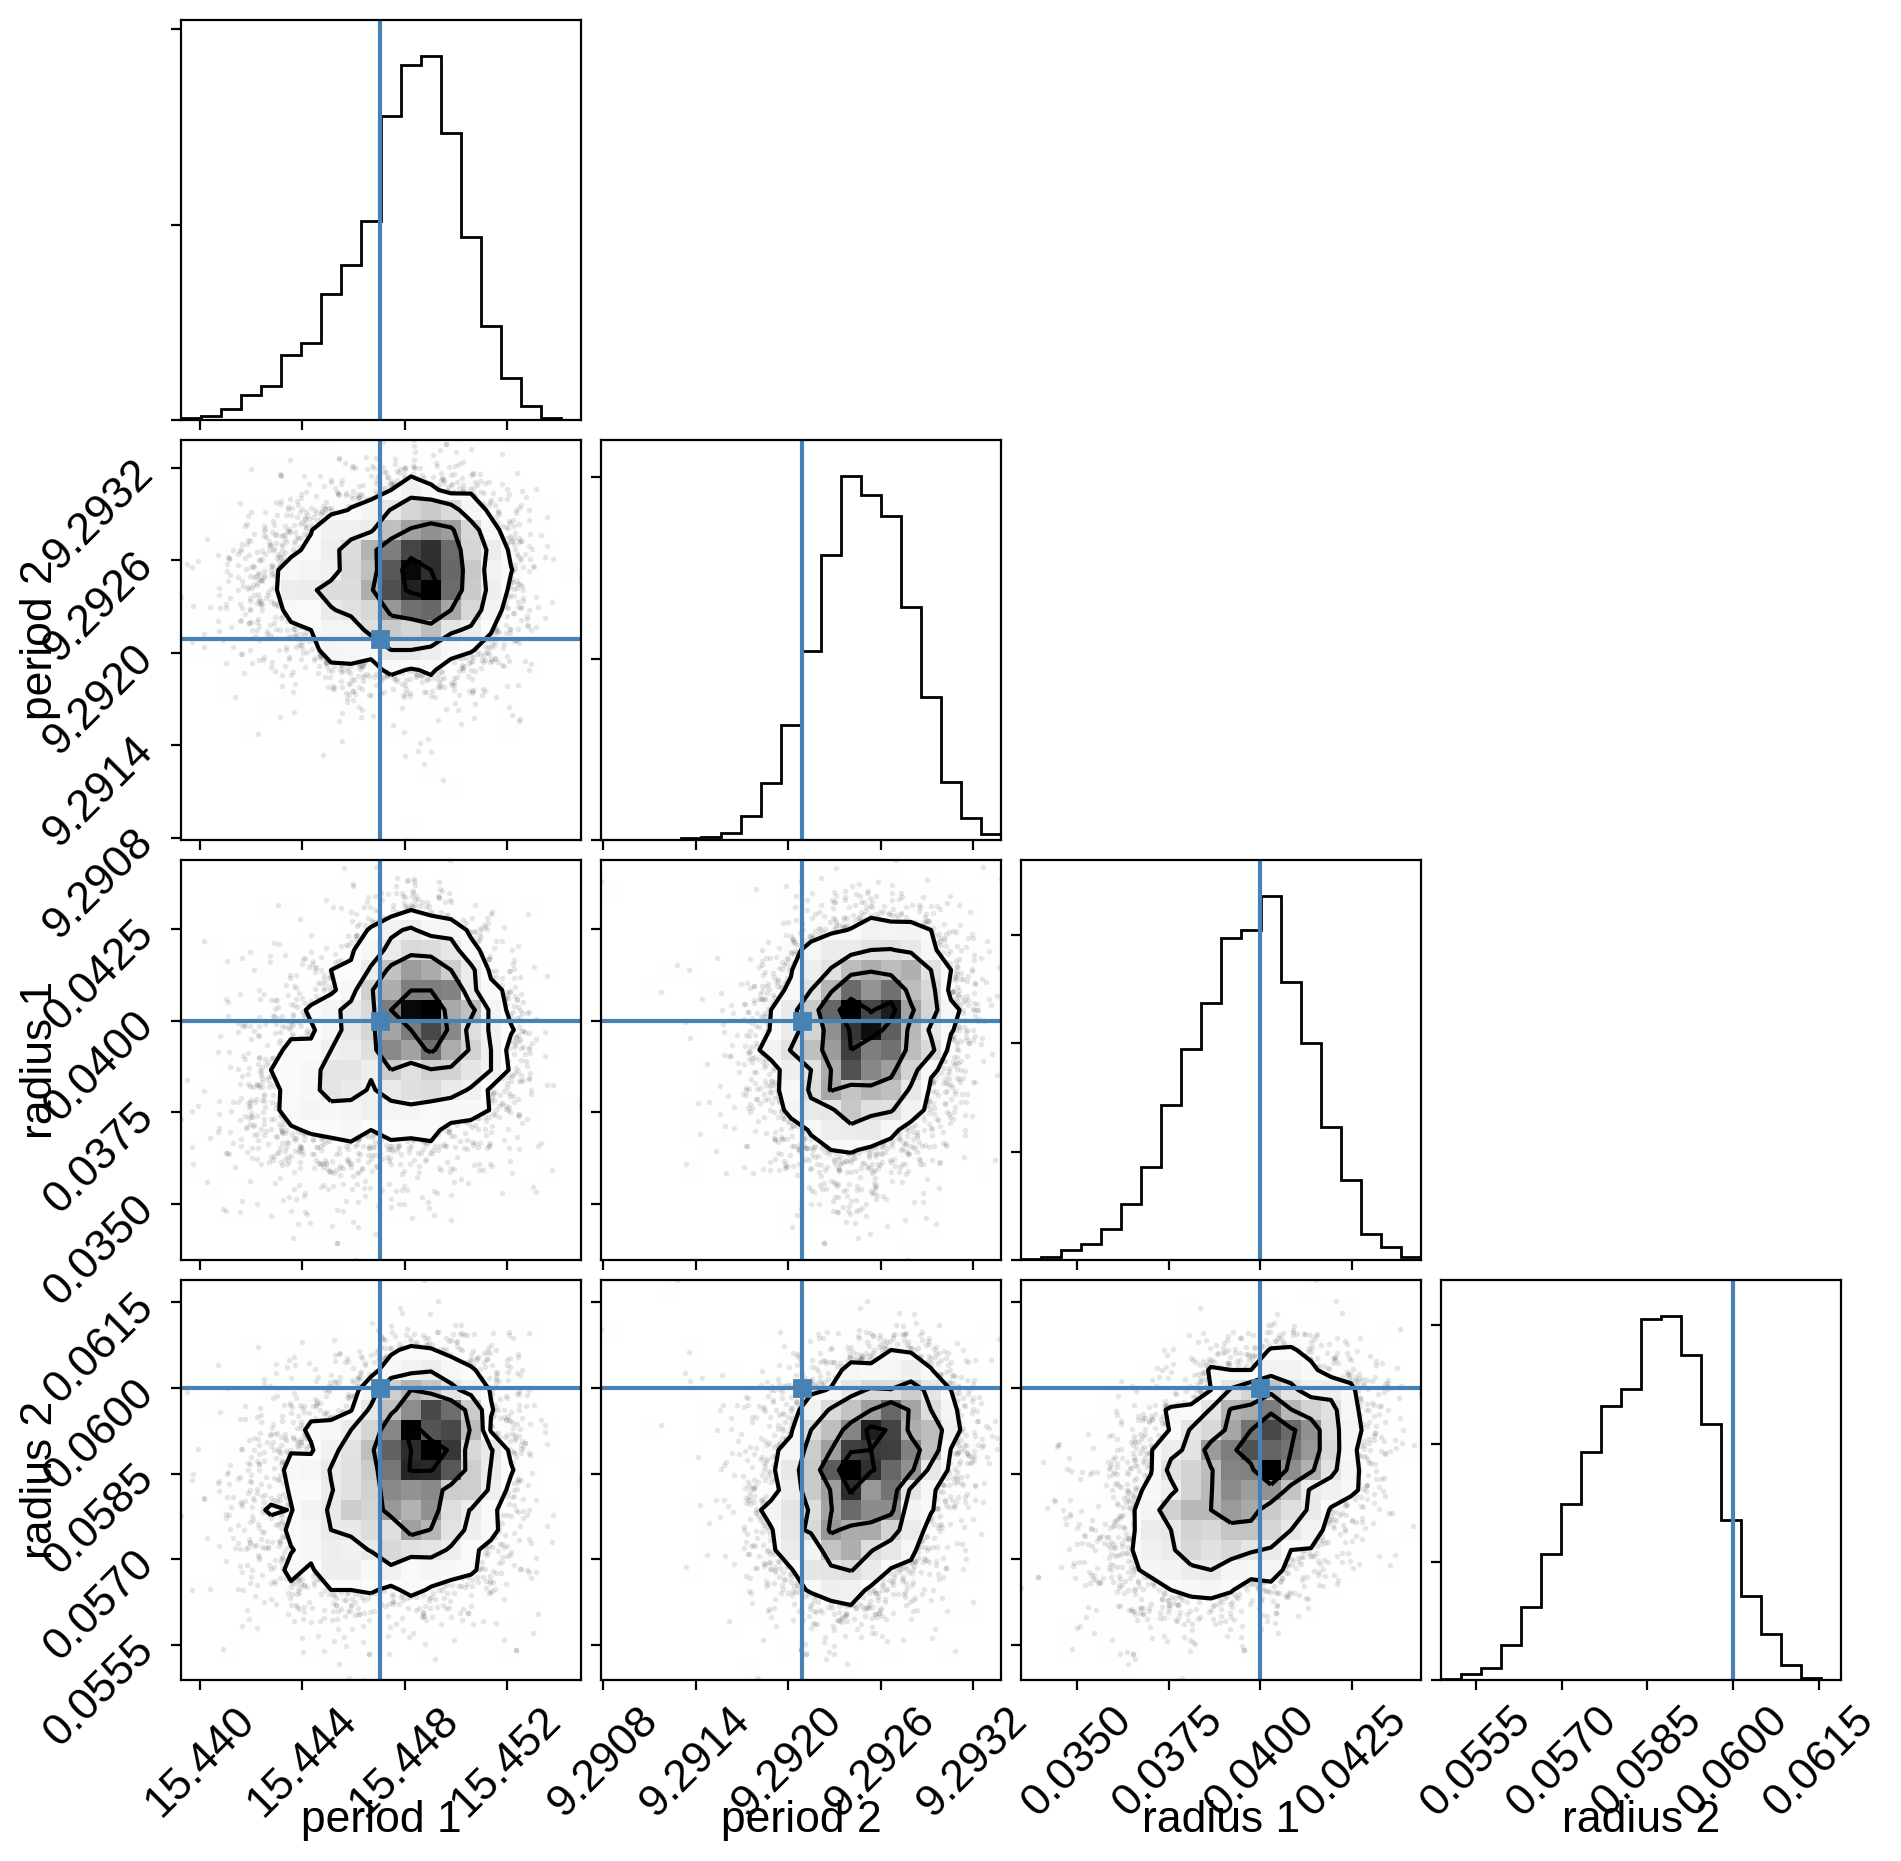

In [9]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["period", "r"])
truth = np.concatenate(
    xo.eval_in_model([period, r], model.test_point, model=model)
)
_ = corner.corner(
    samples,
    truths=truth,
    labels=["period 1", "period 2", "radius 1", "radius 2"],
)

## Phase plots

Like in the radial velocity tutorial (:ref:`rv`), we can make plots of the model predictions for each planet.

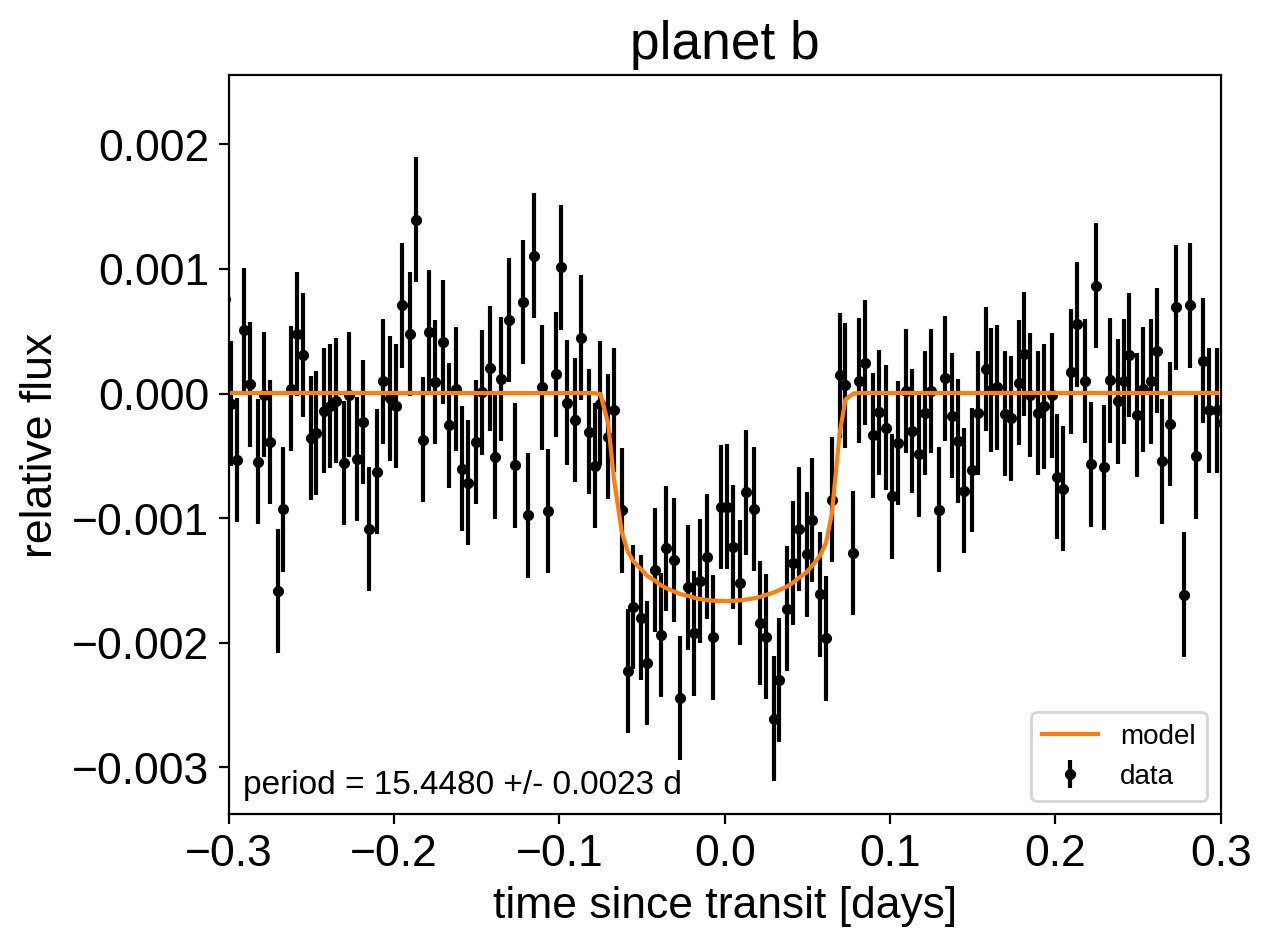

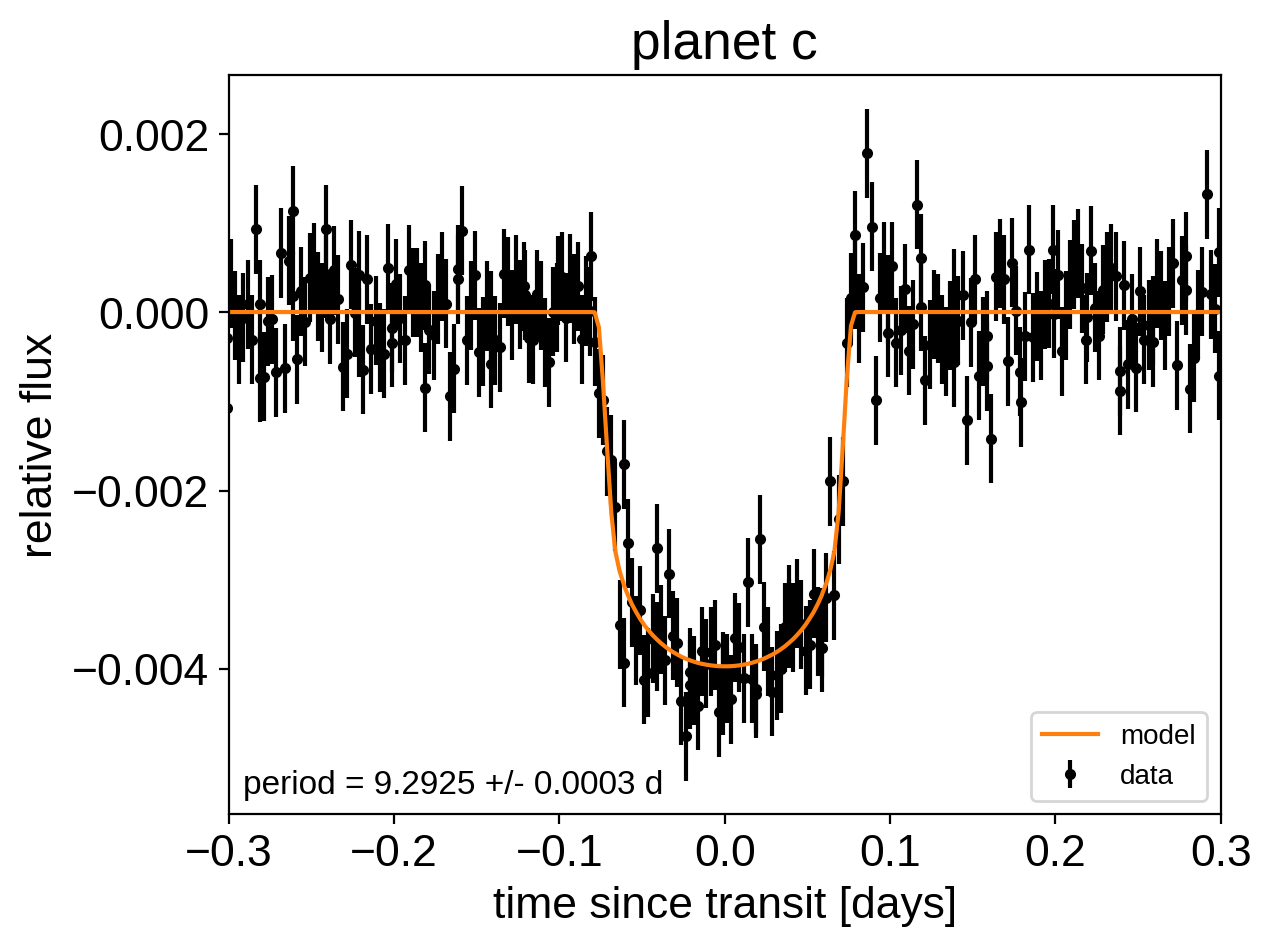

In [10]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(
        x_fold, y - other, yerr=yerr, fmt=".k", label="data", zorder=-1000
    )

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n] + trace["mean"][:, None]
    pred = np.median(pred, axis=0)
    plt.plot(x_fold[inds], pred, color="C1", label="model")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n])
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [11]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3,
exoplanet:theano}.


In [12]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.2.4},
   month = dec,
    year = 2019,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
